In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [2]:
path = Config().data_path()/'mnist'

In [3]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [5]:
x_train = tensor(x_train)
y_train = tensor(y_train)
x_valid = tensor(x_valid)
y_valid = tensor(y_valid)

<class 'torch.Tensor'>


torch.Size([50000, 784])

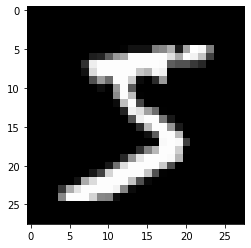

In [6]:
print(type(x_train))
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape # 500000 images,784 pixels

In [7]:
y_train # The correct answers we're trying to predict

tensor([5, 0, 4,  ..., 8, 4, 8])

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [8]:
bs=64
train_ds = TensorDataset(tensor(x_train), tensor(y_train))
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [9]:
# Examples of using the iterable type
i = iter(tensor([[1, 2, 3], [1, 1, 4]]))
print(next(i))
print(next(i))

# More examples of tensors
t = torch.Tensor(10, 784)
t.uniform_(-1, 1)
print(t)
print(t.t())

tensor([1, 2, 3])
tensor([1, 1, 4])
tensor([[-0.4497,  0.9317, -0.5594,  ..., -0.0760, -0.8012,  0.8395],
        [-0.7382, -0.8581,  0.9371,  ...,  0.2997, -0.7259, -0.0388],
        [ 0.3755, -0.5688,  0.4285,  ..., -0.3911,  0.2019, -0.5202],
        ...,
        [ 0.7584, -0.4505, -0.4448,  ...,  0.8495, -0.4001,  0.9217],
        [-0.1263,  0.9979, -0.8490,  ..., -0.7973,  0.7061,  0.5160],
        [ 0.6670, -0.4481,  0.1498,  ...,  0.7310, -0.0881,  0.2066]])
tensor([[-0.4497, -0.7382,  0.3755,  ...,  0.7584, -0.1263,  0.6670],
        [ 0.9317, -0.8581, -0.5688,  ..., -0.4505,  0.9979, -0.4481],
        [-0.5594,  0.9371,  0.4285,  ..., -0.4448, -0.8490,  0.1498],
        ...,
        [-0.0760,  0.2997, -0.3911,  ...,  0.8495, -0.7973,  0.7310],
        [-0.8012, -0.7259,  0.2019,  ..., -0.4001,  0.7061, -0.0881],
        [ 0.8395, -0.0388, -0.5202,  ...,  0.9217,  0.5160,  0.2066]])


In [10]:
# x is the first batch, it's got 64 items, each containing 784 elements
# y is the target, and of course it's also got 64 elements (telling us the labels for each item in x)

x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [11]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
 
    def forward(self, xb): return self.lin(xb)

In [12]:
logistic_model = Mnist_Logistic().cuda()
# if we don't have cuda:
# model = Mnist_Logistic() 
# But, the kernel seems to crash later so idk

In [13]:
logistic_model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [14]:
logistic_model.lin

Linear(in_features=784, out_features=10, bias=True)

In [15]:
# TEST: Why is the weight of this shape?
# We need something that will take 784 inputs and output a probability of 10 numbers
logistic_model.lin.weight.shape

torch.Size([10, 784])

In [16]:
# TEST: Why is this vector of length 10?
# We need to add the bias to 10 different activations resulting from applying 
# the linear transformation to the input using the weights
logistic_model.lin.bias.shape

torch.Size([10])

In [17]:
y_hat = logistic_model(x); y_hat # apply linear transformation to x (using weights)

tensor([[ 0.0426,  0.2684,  0.0586, -0.1682,  0.3938,  0.0585,  0.0297, -0.2372,
         -0.2128,  0.0354],
        [-0.1195, -0.0669, -0.0880, -0.1576, -0.2504, -0.0411,  0.0844,  0.0359,
          0.0947, -0.0898],
        [ 0.1524,  0.1446,  0.0053, -0.2225,  0.1908,  0.0441,  0.1264, -0.1372,
         -0.2776,  0.0534],
        [-0.0139,  0.2076, -0.0378, -0.1691, -0.3415, -0.1077,  0.2600, -0.0520,
         -0.0298, -0.2094],
        [ 0.1056, -0.1086,  0.2380, -0.0965, -0.0626, -0.0736,  0.2558,  0.0353,
         -0.0832, -0.0257],
        [ 0.1628,  0.0752,  0.0253, -0.1726, -0.1324, -0.0911,  0.1971,  0.0056,
          0.0274, -0.3386],
        [ 0.2356,  0.0718, -0.1102, -0.1161, -0.2528,  0.0510,  0.3541, -0.2202,
          0.0623, -0.3440],
        [ 0.3403, -0.2569, -0.0305, -0.1009, -0.3237,  0.0040,  0.1718, -0.1857,
         -0.0386, -0.4002],
        [ 0.1082, -0.0443,  0.2007, -0.1574,  0.0611,  0.1871,  0.2243, -0.0516,
         -0.1991, -0.0571],
        [ 0.1981,  

In [18]:
y_hat.shape

torch.Size([64, 10])

In [20]:
# Where did these parameters come from? From the linear model weight and bias!!
# See In[86] and In[87] -- they have the same shape
# Interesting, so Parameters are persisted/registered with some global object/store
[p.shape for p in logistic_model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [21]:
lr=2e-2

In [22]:
loss_func = nn.CrossEntropyLoss()

In [23]:
def update(model,x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    # Calling loss.backward() computes dloss/dx 
    # for every parameter x which has requires_grad=True
    # These are accumulated into x.grad for every parameter x. In pseudo-code:
    # x.grad += dloss/dx
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [24]:
# Calculate the losses by BATCHES of 64 items each
# If we accidentally run this too many times we'll overfit
# and get a weird graph
losses = [update(logistic_model, x,y,lr) for x,y in data.train_dl]

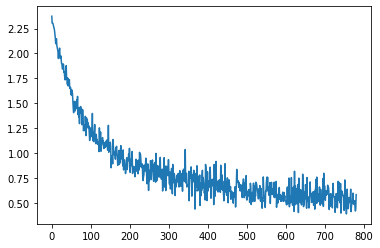

In [25]:
plt.plot(losses);

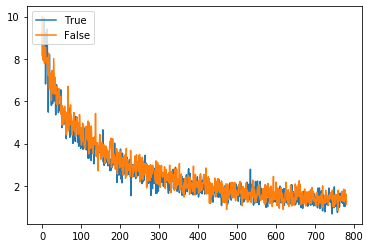

In [26]:
from torch.nn.parameter import Parameter

# Exercise: Implemenet your own MyLinear function
# Woohoo, it worked out OK
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features 
        # Weights is just a vector that's initialized to ([out_features, in_features])
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        
        if bias:
            # CONFUSED: Why add an additional bias number that is equal to the out_features?
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            # TODO: Look at Module and what it does... it seems to keep track of parameters
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    # This function exists just to fill out our weights and bias
    # with some sensible random numbers
    # In the real version they do some complicated shit
    # https://pytorch.org/docs/stable/_modules/torch/nn/init.html#linear
    # But for our version let's just set it to something dumb
    # shouldn't matter too much bc it gets updated after every run
    def reset_parameters(self):
        with torch.no_grad():
            self.weight.uniform_(-1, 1)
            if self.bias is not None:
                self.bias.uniform_(-1, 1)
    
    # The bias is ADDITIVE
    def forward(self, input):
        output = input.matmul(self.weight.t()) # multiply the input by the weights
        if self.bias is not None:
            output += self.bias
            
        return output
    
class My_Mnist_Logistic(nn.Module):
    def __init__(self, bias=True):
        super().__init__()
        self.lin = MyLinear(784, 10, bias)

    def forward(self, xb): return self.lin(xb)

# Bias doesn't seem to make a big difference here
for with_bias in [True, False]:
    model = My_Mnist_Logistic(bias=with_bias).cuda()
    losses = [update(model,x,y,lr) for x,y in data.train_dl]
    plt.plot(losses, label = str(with_bias))
    plt.legend(loc='upper left')

In [27]:
# So we did the logistic regression, now time to build a neural net
# We have 2 linear layers here
# the first takes 784 inputs and outputs 50 activations
# the second takes 50 inputs and outputs 10 activations
# We will also use relu between those layers (interestingly, not at the end!)
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [31]:
nn_model = Mnist_NN().cuda()

In [32]:
losses = [update(nn_model, x,y,lr) for x,y in data.train_dl]

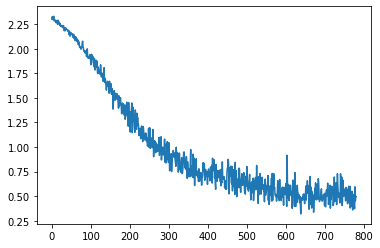

In [33]:
plt.plot(losses);

In [34]:
model = Mnist_NN().cuda()

In [35]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [36]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

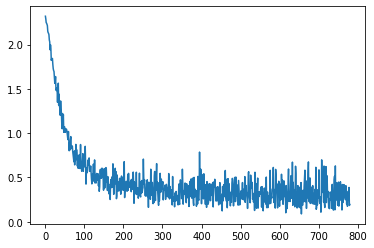

In [37]:
plt.plot(losses);

In [43]:
# Interesting to note is that we are NOT callng cuda() here
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [41]:
# %debug

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


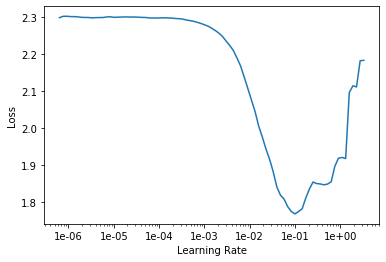

In [42]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.134164,0.124682,0.964300,00:04


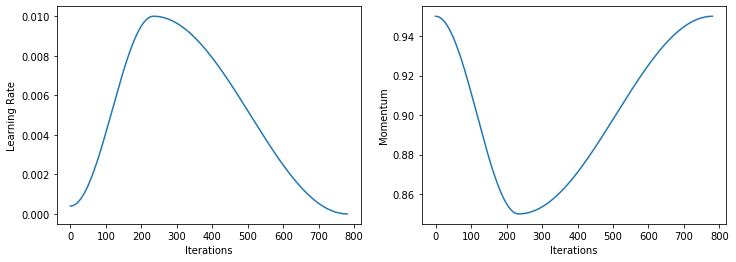

In [47]:
# There is a trade-off between learning rat and momentum
# When we're already taking very big big steps we don't need a lot of momentum
# BUt when we are taking tiny steps it's good to go a little faster depending on
# past steps (if it's all been in the same direction, well, go faster!)
learn.recorder.plot_lr(show_moms=True)

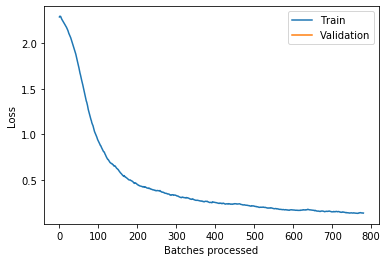

In [46]:
learn.recorder.plot_losses()

## fin